<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/MLSec_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Adversarial Attacks on Deep Neural Networks

## Overview
In this lab, you will investigate adversarial perturbation attacks on Deep Neural Networks using the MNIST digits dataset as a benchmark. You will then evaluate adversarial retraining as a defense against adversarial perturbations.

## Dataset
The fashion_MNIST dataset is a commonly used “toy” benchmarks for machine learning. It contains 28X28 grayscale images with a label from 10 classes, along with the associated labels. The dataset is available as part of the tensorflow package, which you will be using extensively in this lab.

## What You Have to Do
The sample Google Colab notebook
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb#scrollTo=h3IKyzTCDNGo
that implements a 2-layer DNN for MNIST digit classification. The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations. You will implement your attacks and defenses on this baseline DNN.

* **FGSM based untargeted attacks**: Your first goal is to implement FGSM based untargeted attacks using images from the test set on the baseline DNN. That is, your goal is to adversarially perturb each image in the test set using the following values of parameter $\epsilon$ = {1, 5, 10, 20, 30, 40, 50}/255 assuming pixel values are normalized in the range [0,1]. Report the success rate of your attack, i.e., the fraction of test images that were
correctly classified by the baseline DNN that are mis-classified after adversarial perturbation, as a function of $\epsilon$.

* **FGSM based targeted attacks**: Next, you will repeat Step 1 above, except this time perform targeted attacks where digit i is classified as (i+1)%10 on the baseline DNN. (Here, i refers to the true ground-truth label of the test images, and you can assume that the attacker has access to these labels.) As before, use the following values of the parameter $\epsilon$ = {1, 5, 10, 20, 30, 40, 50}/255. Report the attack’s success rate as a function of parameter $\epsilon$, where success rate is defined as the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbations with label (i+1)%10.

* **Adversarial Retraining against Untargeted FGSM Attacks**: For this step, you can assume $\epsilon$ = 10/255 throughout. To defend against adversarial perturbations, the defender adversarially perturbs each image in her training set using the attacker’s strategy in Step 1. She then appends the adversarially perturbed images to her training set, but using their correct labels. Then, the defender retrains the baseline DNN with a new training dataset containing both images from the original training dataset and the new adversarially perturbed images. We call the new DNN the adversarially retrained DNN.

  *  Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs.
  * Is the adversarially retrained DNN robust against adversarial perturbations?
Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Report the success rate of your attack.

* **Challenge**: Finally, you will all compete in an adversarial attack challenge. You are free to use any adversarial attack detection procedure to implement untargeted attacks on a 2-layer baseline DNN. You are welcome to implement IFGSM or PGD attacks for example. For this problem you will simply submit your adversarially perturbed test images from the Fashion_MNIST dataset. The constraint is that the Root Mean Square Error averaged over all the images in the the original and modified datasets should be less than 5/255. assuming images are normalized to lie between [0,1].

## What to Submit
* Colab Notebook and its pdf format.
* Please submit 1 Colab Notebook and 1 PDF file without zipping.
* For the Challenge, please submit a file containing your adversarially modified test images



https://nextjournal.com/gkoehler/pytorch-mnist

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

https://towardsdatascience.com/know-your-enemy-the-fascinating-implications-of-adversarial-examples-5936bccb24af

https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/

https://www.pyimagesearch.com/2020/10/26/targeted-adversarial-attacks-with-keras-and-tensorflow/

https://www.pyimagesearch.com/2020/10/19/adversarial-images-and-attacks-with-keras-and-tensorflow/

https://www.pyimagesearch.com/2021/03/01/adversarial-attacks-with-fgsm-fast-gradient-sign-method/

## Import packages and Get Data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              ## transform range to [0,1],default is [0,1]
                              #transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transform, 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transform,
    download = True,  
)

In [4]:
print("The train data size is: ", train_data.data.size())
print("The test data size is: ", test_data.data.size())

The train data size is:  torch.Size([60000, 28, 28])
The test data size is:  torch.Size([10000, 28, 28])


We will visualize the data

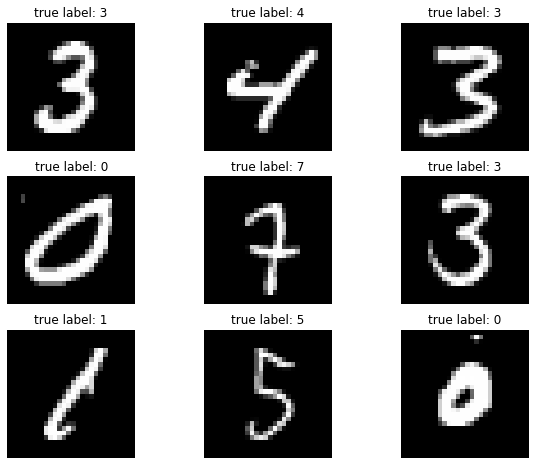

In [5]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = torch.randint(len(train_data),size=(1,)).item()
  img, label = train_data[index]
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We need to prepare the dataloader for training

In [57]:
loaders = {
    'train':DataLoader(train_data,
                       batch_size = 64,
                       shuffle = True,
                       ),
    'test':DataLoader(test_data,
                      batch_size = 64,
                      shuffle = True,
                      ),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f6a77413fd0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f6a77413e90>}

torch.Size([64, 1, 28, 28])
torch.float32
torch.Size([64])


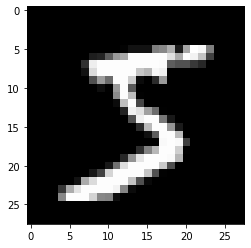

In [9]:
dataiter = iter(loaders['train'])
images, labels = dataiter.next()

print(images.shape)
print(images.dtype)
print(labels.shape)
plt.imshow(images[0].squeeze(), cmap="gray")

## Baseline DNN model
The DNN has a 784 (28x28) dimensional input, a 10-dimensional output (prediction probabilities for each of the 10 classes) and one hidden layer with 300 hidden neurons and ReLU activations.

In [10]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.DNNBlock = nn.Sequential(
        # DNN has 28*28 dimensional input and one hidden layer with 300 neurons
        nn.Linear(28*28, 300),
        nn.ReLU(),
        nn.Linear(300, 10),
        nn.LogSoftmax(dim=1)
    )
  def forward(self, x):
    # flatten the input to 784
    x = x.view(x.shape[0],-1)
    x = self.DNNBlock(x)
    return x
DNN = DNN()
# ## we will print out the structure to see if it is correct
print(DNN)

DNN(
  (DNNBlock): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


In [11]:
loss_func = nn.NLLLoss()

We will start to train the DNN model

In [12]:
optimizer = optim.Adam(DNN.parameters(), lr = 0.01) 
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [13]:
num_epochs = 10
def train_DNN(num_epochs, model, loaders, trainOrTest):
  model.train()
  loss_record = []
  total_step = len(loaders['train'])
  for epoch in range(num_epochs):
    sum_loss = []
    for i, (imgs, labels) in enumerate(loaders[trainOrTest]):
      optimizer.zero_grad()
      x = Variable(imgs) # batch size is 64
      y = Variable(labels) # batch size is 64
      pred = model(x)
      loss = loss_func(pred, y)    
      loss.backward()
      optimizer.step()
      sum_loss.append(loss.item())
    final_loss = np.sum(sum_loss)/len(sum_loss)
    loss_record.append(final_loss)
    print('epoch:[{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs,final_loss))
  return loss_record

loss = train_DNN(num_epochs, DNN, loaders, 'train')


epoch:[1/10], loss:0.2365
epoch:[2/10], loss:0.1437
epoch:[3/10], loss:0.1240
epoch:[4/10], loss:0.1123
epoch:[5/10], loss:0.1008
epoch:[6/10], loss:0.0910
epoch:[7/10], loss:0.0801
epoch:[8/10], loss:0.0864
epoch:[9/10], loss:0.0784
epoch:[10/10], loss:0.0759


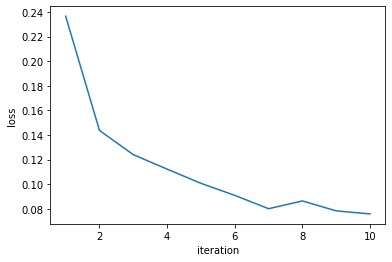

In [14]:
plt.plot(range(1,11),loss)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [15]:
def DNN_acc(model, loaders, trainOrTest):
  correct_count, all_count = 0, 0
  y_pred = []
  y_true = []
  for img, label in loaders[trainOrTest]:
    for i in range(len(label)):
      prob = DNN(img[i])
      ps = torch.exp(prob)
      probab = list(ps.detach().numpy()[0])
      pred_label = probab.index(max(probab))
      true_label = label.numpy()[i]
      y_pred.append(pred_label)
      y_true.append(true_label)
      
      if(true_label==pred_label):
        correct_count+=1
      all_count+=1
  return correct_count/all_count, y_pred, y_true

In [ ]:
acc, y_pred, y_test = DNN_acc(DNN, loaders, 'test')

In [ ]:
print("The accuracy of DNN model is: ",acc)

The accuracy of DNN model is:  0.9681


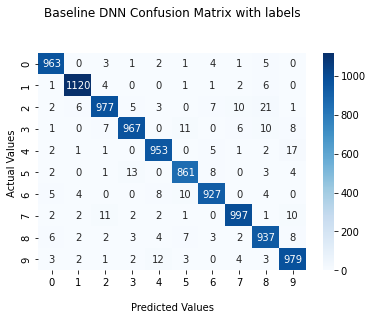

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline DNN Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

## FGSM based untargeted attacks

In [16]:
def generate_adv_img(model, loaders, epsilon, trainOrTest):
  adv_img = []
  img_label = []
  for i, (img, label) in enumerate(loaders[trainOrTest]):
    x = Variable(img, requires_grad=True) # batch size is 64
    y = Variable(label) # batch size is 64

    pred = model(x)
    loss = loss_func(pred, y)  
    loss.backward()
    grad = x.grad.data
    sign = torch.sign(grad)
    new_img = torch.clamp((x+(sign*epsilon)),min=0,max=1)
    adv_img.append(new_img)
    img_label.append(y)
  return adv_img, img_label

In [17]:
def DNN_acc_adv(model, adv_img, img_label):
  correct_count, all_count = 0, 0
  y_pred = []
  y_true = []
  for i,img in enumerate(adv_img):
    for j in range(adv_img[i].shape[0]):
      prob = DNN(img[j])
      ps = torch.exp(prob)
      probab = list(ps.detach().numpy()[0])
      pred_label = probab.index(max(probab))
      true_label = img_label[i].numpy()[j]
      y_pred.append(pred_label)
      y_true.append(true_label)
      
      if(true_label==pred_label):
        correct_count+=1
      all_count+=1
  return correct_count/all_count, y_pred, y_true

In [ ]:
epsilon = [1/255, 5/255, 10/255, 20/255, 30/255, 40/255, 50/255]
acc_adv_final = []
y_pred_final = []
success_attack_rate = []
for eps in epsilon:
  adv_img, img_label = generate_adv_img(DNN, loaders, eps, 'test')
  acc_adv, y_pred_adv, y_test_adv = DNN_acc_adv(DNN, adv_img, img_label)
  success_attack_rate.append(1-accuracy_score(y_pred_adv, y_test_adv))
  acc_adv_final.append(acc_adv)
  y_pred_final.append(y_pred_adv)

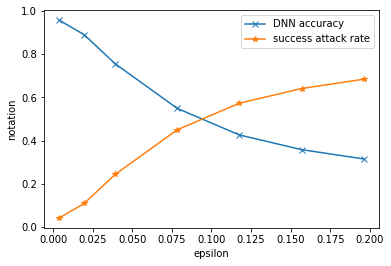

In [ ]:
plt.plot(epsilon,acc_adv_final,marker='x')
plt.plot(epsilon,success_attack_rate,marker='*')
plt.xlabel('epsilon')
plt.ylabel('notation')
plt.legend(['DNN accuracy','success attack rate'])

we can check the image too

## FGSM based targeted attacks

In [54]:
def generate_target_adv(model, loaders, epsilon, trainOrTest):
  adv_tar_img = []
  true_label =[]
  modify_label = []
  for i, (img, label) in enumerate(loaders[trainOrTest]):
    x = Variable(img, requires_grad=True) # batch size is 64
    y = Variable(label) # batch size is 64
    true_label.append(y.clone())
    pred = model(x)
    
    for index, real_label in enumerate(y):
      y[index] = (real_label + 1)%10
    modify_label.append(y)
    loss = loss_func(pred, y)
    loss.backward()
    grad = x.grad.data
    sign = torch.sign(grad)
    new_img = torch.clamp((x-(sign*epsilon)),min=0,max=1)
    adv_tar_img.append(new_img)
  return adv_tar_img, true_label, modify_label

In [91]:
adv_tar_img, true_label, modify_label = generate_target_adv(DNN, loaders, 50/255, 'test')

In [96]:
print(modify_label[0])
print(true_label[0])
print(y_tar_pred_adv.count(8))

tensor([4, 6, 4, 7, 8, 8, 5, 3, 2, 6, 4, 2, 7, 2, 7, 6, 7, 3, 3, 1, 4, 2, 4, 0,
        5, 2, 8, 3, 2, 3, 0, 4, 2, 7, 5, 8, 2, 2, 7, 1, 0, 2, 5, 9, 9, 7, 4, 3,
        5, 9, 2, 0, 0, 8, 4, 8, 2, 9, 6, 0, 1, 5, 0, 5])
tensor([3, 5, 3, 6, 7, 7, 4, 2, 1, 5, 3, 1, 6, 1, 6, 5, 6, 2, 2, 0, 3, 1, 3, 9,
        4, 1, 7, 2, 1, 2, 9, 3, 1, 6, 4, 7, 1, 1, 6, 0, 9, 1, 4, 8, 8, 6, 3, 2,
        4, 8, 1, 9, 9, 7, 3, 7, 1, 8, 5, 9, 0, 4, 9, 4])
6313


In [92]:
acc_tar_adv, y_tar_pred_adv, y_tar_test_adv = DNN_acc_adv(DNN, adv_tar_img, true_label)

In [93]:
print(acc_tar_adv)

0.0811


In [94]:
print(len(y_tar_pred_adv))
li_tal = []
for li in modify_label:
  li_tal+=li
print(type(li_tal))

10000
<class 'list'>


In [ ]:
print(y_tar_pred_adv)
print(li_tal)

In [76]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_tar_pred_adv, li_tal)
print(score)

0.0357


In [95]:
count=0
for index, val in enumerate(li_tal):
  if (val)==y_tar_pred_adv[index]:
    count+=1
print(count)

2445


## Adversarial Retraining against Untargeted FGSM Attacks

In [18]:
class DNN_adv(nn.Module):
  def __init__(self):
    super(DNN_adv, self).__init__()
    self.DNNBlock = nn.Sequential(
        # DNN has 28*28 dimensional input and one hidden layer with 300 neurons
        nn.Linear(28*28, 300),
        nn.ReLU(),
        nn.Linear(300, 10),
        nn.LogSoftmax(dim=1)
    )
  def forward(self, x):
    # flatten the input to 784
    x = x.view(x.shape[0],-1)
    x = self.DNNBlock(x)
    return x
DNN_adv = DNN_adv()
# ## we will print out the structure to see if it is correct
print(DNN_adv)

DNN_adv(
  (DNNBlock): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


In [19]:
epsilon_adv = 10/255

adv_img_new, img_label_new = generate_adv_img(DNN, loaders, epsilon_adv, 'train')
for i, (img, label) in enumerate(loaders['train']):
  adv_img_new.append(img)
  img_label_new.append(label)

In [ ]:
print(adv_img_new[0])
print(adv_img_new[938])

In [20]:
optimizer_adv = optim.Adam(DNN_adv.parameters(), lr = 0.01) 
optimizer_adv

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [21]:
num_epochs = 10
def train_DNN_adv(num_epochs, model, adv_img_new, img_label_new):
  model.train()
  loss_record = []
  for epoch in range(num_epochs):
    sum_loss = []
    for i, imgs in enumerate(adv_img_new):
      optimizer_adv.zero_grad()
      x = Variable(imgs) # batch size is 64
      y = Variable(img_label_new[i]) # batch size is 64
      pred = model(x)
      loss = loss_func(pred, y)    

      
      loss.backward()
      optimizer_adv.step()
      sum_loss.append(loss.item())
    final_loss = np.sum(sum_loss)/len(sum_loss)
    loss_record.append(final_loss)
    print('epoch:[{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs,final_loss))
  return loss_record

loss_adv = train_DNN_adv(num_epochs, DNN_adv, adv_img_new, img_label_new)

epoch:[1/10], loss:0.1960
epoch:[2/10], loss:0.1154
epoch:[3/10], loss:0.0991
epoch:[4/10], loss:0.0862
epoch:[5/10], loss:0.0760
epoch:[6/10], loss:0.0737
epoch:[7/10], loss:0.0695
epoch:[8/10], loss:0.0607
epoch:[9/10], loss:0.0659
epoch:[10/10], loss:0.0634


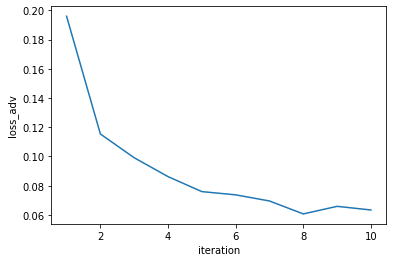

In [22]:
plt.plot(range(1,11),loss_adv)
plt.xlabel("iteration")
plt.ylabel("loss_adv")
plt.show()

In [23]:
def DNN_adv_acc_new(model, loaders, trainOrTest):
  correct_count, all_count = 0, 0
  y_pred = []
  y_true = []
  for img, label in loaders[trainOrTest]:
    for i in range(len(label)):
      prob = model(img[i])
      ps = torch.exp(prob)
      probab = list(ps.detach().numpy()[0])
      pred_label = probab.index(max(probab))
      true_label = label.numpy()[i]
      y_pred.append(pred_label)
      y_true.append(true_label)
      
      if(true_label==pred_label):
        correct_count+=1
      all_count+=1
  return correct_count/all_count, y_pred, y_true

acc_adv_new, y_pred_new, y_test_new = DNN_adv_acc_new(DNN_adv, loaders, 'test')

In [24]:
print(acc_adv_new)

0.9687


In [25]:
adv_test_img, img_test_label = generate_adv_img(DNN_adv, loaders, epsilon_adv, 'test')

In [26]:
acc_adv_new_test, y_pred_adv_new, y_test_adv_new = DNN_acc_adv(DNN_adv, adv_test_img, img_test_label)

In [27]:
print(acc_adv_new_test)

0.9496


## Challenge

In [69]:
fashion_train_data = datasets.FashionMNIST(
    root = 'data', 
    train = True, 
    transform = transform,
    download = True,  
)
fashion_test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = transform,
    download = True,  
)

In [70]:
print("The train data size is: ", fashion_train_data.data.size())
print("The test data size is: ", fashion_test_data.data.size())

The train data size is:  torch.Size([60000, 28, 28])
The test data size is:  torch.Size([10000, 28, 28])


In [71]:
fashion_loaders = {
    'train':DataLoader(fashion_train_data,
                      batch_size = 64,
                      shuffle = True,
                      ),
    'test':DataLoader(fashion_test_data,
                      batch_size = 64,
                      shuffle = True,
                      ),
}
fashion_loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f6a77240fd0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f6a77240f50>}

In [72]:
class fashion_DNN(nn.Module):
  def __init__(self):
    super(fashion_DNN, self).__init__()
    self.DNNBlock = nn.Sequential(
        # DNN has 28*28 dimensional input and one hidden layer with 300 neurons
        nn.Linear(28*28, 300),
        nn.ReLU(),
        nn.Linear(300, 10),
        nn.LogSoftmax(dim=1)
    )
  def forward(self, x):
    # flatten the input to 784
    x = x.view(x.shape[0],-1)
    x = self.DNNBlock(x)
    return x
fashion_DNN = fashion_DNN()
# ## we will print out the structure to see if it is correct
print(fashion_DNN)

fashion_DNN(
  (DNNBlock): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=10, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


In [75]:
optimizer_challenge = optim.Adam(fashion_DNN.parameters(), lr = 0.01) 
optimizer_challenge

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [76]:
num_epochs = 10
def train_fashion_DNN(num_epochs, model, loaders, trainOrTest):
  model.train()
  loss_record = []
  total_step = len(loaders['train'])
  for epoch in range(num_epochs):
    sum_loss = []
    for i, (imgs, labels) in enumerate(loaders[trainOrTest]):
      optimizer_challenge.zero_grad()
      x = Variable(imgs) # batch size is 64
      y = Variable(labels) # batch size is 64
      pred = model(x)
      loss = loss_func(pred, y)    
      loss.backward()
      optimizer_challenge.step()
      sum_loss.append(loss.item())
    final_loss = np.sum(sum_loss)/len(sum_loss)
    loss_record.append(final_loss)
    print('epoch:[{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs,final_loss))
  return loss_record

loss = train_fashion_DNN(num_epochs, fashion_DNN, fashion_loaders, 'train')

epoch:[1/10], loss:0.5045
epoch:[2/10], loss:0.4121
epoch:[3/10], loss:0.3783
epoch:[4/10], loss:0.3719
epoch:[5/10], loss:0.3566
epoch:[6/10], loss:0.3454
epoch:[7/10], loss:0.3399
epoch:[8/10], loss:0.3330
epoch:[9/10], loss:0.3288
epoch:[10/10], loss:0.3253


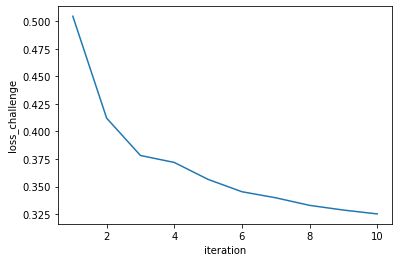

In [77]:
plt.plot(range(1,11),loss)
plt.xlabel("iteration")
plt.ylabel("loss_challenge")
plt.show()

In [78]:
def generate_adv_img_challenge(model, numberOfEpoch, loaders, alpha, trainOrTest):
  adv_img = []
  ori_img = []
  
  for i, (img, label) in enumerate(loaders[trainOrTest]):
    new_img = img
    ori_img.append(img)
    image_label = label
    for epoch in range(numberOfEpoch):
      x = Variable(new_img, requires_grad=True) # batch size is 64
      y = Variable(label) # batch size is 64

      pred = model(x)
      loss = loss_func(pred, y)  
      loss.backward()
      grad = x.grad.data
      sign = torch.sign(grad)
      new_img = torch.clamp((x+(sign*alpha)),min=0,max=1)
    adv_img.append(new_img)
  return adv_img, ori_img

In [79]:
adv_img_challenge, ori_img = generate_adv_img_challenge(fashion_DNN, 5, fashion_loaders, 1/255, 'test')

In [80]:
def calRMSE(adv_img, ori_img):
  RMSE = []
  for i, img in enumerate(adv_img):
    for index, image in enumerate(img):
      rmse = torch.sqrt(torch.sum((image-ori_img[i][index])**2)/(28*28))
      RMSE.append(rmse)
    #rmse = torch.sqrt(torch.sum((img-adv_img[i])**2)/(28*28*64))
    #print(rmse)
    
  return RMSE

In [81]:
RMSE = calRMSE(adv_img_challenge, ori_img)

In [82]:
print(len(RMSE))

10000


In [83]:
print(np.sum(RMSE)/len(RMSE))

tensor(0.0163, grad_fn=<DivBackward0>)
